# Notes

- Data taken from here: https://github.com/churchlab/Deep_diversification_AAV/tree/main/Data
- Just sequence (AA) data exists as well here: https://www.dropbox.com/sh/lmd8wmgibz24r2h/AADmgvc_0Q5mylwgGf97cTC-a/ML_and_Analysis/model_and_dataset_analysis/allseqs_20191230.csv.zip?dl=0
- [This notebook](https://github.com/churchlab/Deep_diversification_AAV/blob/main/Parsing_pipeline/Step3_compute_selection_scores.ipynb) suggest that the "target" column is `GAS1_virus_S` in the CSV file
- [This repository](https://github.com/google-research/google-research/tree/master/aav/model_training) suggest that the wild type AA sequence is 28 residues and is `DEEEIRTTNPVATEQYGSVSTNLQRGNR`
- Cutoff via gaussian mixture copied from: https://colab.research.google.com/github/google-research/google-research/blob/master/aav/model_and_dataset_analysis/data_prep.ipynb
- The UniProt sequence is here: https://www.uniprot.org/uniprot/P03135
- In UniProt notation (sequence starts at 1), the region on P03135 where the sequence mutates is `[561, 588]`

In [1]:
!pip install biopython
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install python-Levenshtein

In [2]:
import pandas
import math
import random
import Levenshtein
import numpy

from pathlib import Path
from pandas import read_csv, DataFrame

from helpers import read_fasta, TwoGaussianMixtureModelLabeler

In [3]:
random.seed(11)

In [4]:
pandas.set_option('display.max_rows', None)

In [5]:
data_path = Path('') / '..' / 'data' / 'aav'
aav_data_path = data_path / 'library_w_selection_scores.csv'

task_path = Path('') / '..' / 'tasks' / 'aav'

In [6]:
aav_data = read_csv(aav_data_path, index_col=0)

P03135 = read_fasta(data_path / 'P03135.fasta')[0]
region = (561,588)
reference_region = "DEEEIRTTNPVATEQYGSVSTNLQRGNR"

In [7]:
aav_data.columns

Index(['nt_seq', 'EK266_GAS1_p1_rep1a_plasmid', 'EK266_GAS1_p1_rep1b_plasmid',
       'EK269_GAS1_p1_rep1a_plasmid_x', 'EK269_GAS1_p1_rep1b_plasmid_x',
       'EK269_GAS1_p1_rep1c_plasmid_x', 'EK269_GAS1_p1_rep1d_plasmid_x',
       'EK269_GAS1_v3_rep1a_virus_x', 'EK269_GAS1_v3_rep1b_virus_x',
       'EK269_GAS1_v3_rep1c_virus_x', 'EK269_GAS1_v3_rep1d_virus_x',
       'EK269_GAS1_v4_rep2a_virus_x', 'EK269_GAS1_v4_rep2b_virus_x',
       'EK269_GAS1_v4_rep2c_virus_x', 'EK269_GAS1_v4_rep2d_virus_x',
       'EK269_GAS1_v5_rep3a_virus_x', 'EK269_GAS1_v5_rep3b_virus_x',
       'EK269_GAS1_v5_rep3c_virus', 'EK269_GAS1_v5_rep3d_virus', 'aa_x',
       'category_x', 'chip_x', 'control_x', 'is_wt_aa_x', 'is_wt_nt_x',
       'mask_x', 'mut_x', 'rep_i', 'rep_original_x', 'rep_total_x',
       'EK269_GAS1_p1_rep1a_plasmid_y', 'EK269_GAS1_p1_rep1b_plasmid_y',
       'EK269_GAS1_p1_rep1c_plasmid_y', 'EK269_GAS1_p1_rep1d_plasmid_y',
       'EK269_GAS1_v3_rep1a_virus_y', 'EK269_GAS1_v3_rep1b_virus_y',
  

In [8]:
aav_data['category_x'].unique()

array(['rnn_designed_plus_rand_train_walked',
       'rnn_designed_plus_rand_train_seed',
       'rnn_rand_doubles_plus_singles_walked',
       'rnn_rand_doubles_plus_singles_seed', 'rnn_standard_walked',
       'rnn_standard_seed', 'cnn_designed_plus_rand_train_walked',
       'cnn_designed_plus_rand_train_seed',
       'cnn_rand_doubles_plus_single_walked',
       'cnn_rand_doubles_plus_single_seed', 'cnn_standard_walked',
       'cnn_standard_seed', 'lr_designed_plus_rand_train_walked',
       'lr_designed_plus_rand_train_seed',
       'lr_rand_doubles_plus_single_walked',
       'lr_rand_doubles_plus_single_seed', 'lr_standard_walked',
       'lr_standard_seed', 'previous_chip_viable',
       'previous_chip_nonviable', 'stop', 'singles', 'wild_type',
       'random_doubles'], dtype=object)

In [9]:
# Get the wild type sequence from the data

wt = aav_data[aav_data['is_wt_nt_x'] == 1].to_dict(orient='records')[0]

In [10]:
# Make sure that all assumptions on the wild type are correct

assert(wt['aa_x'] == reference_region)

# Important: region[0] -1 because UniProt notation! (0 in Python == 1 in UniProt)
assert(wt['aa_x'] == str(P03135[region[0]-1 : region[1]].seq))

# Make sure chopping the sequence works as expected:

assert(
    str(P03135.seq) ==
    str(P03135[:region[0]-1].seq) + str(P03135[region[0]-1 : region[1]].seq) + str(P03135[region[1]:].seq)
)

In [11]:
protein_data = aav_data[['aa_x', 'mask_x', 'GAS1_virus_S', 'category_x', 'mut_x']].copy()

In [12]:
# Remove data where GAS1_virus_S is +/- inf
#protein_data = protein_data[protein_data['GAS1_virus_S'] != math.inf]
#protein_data = protein_data[protein_data['GAS1_virus_S'] != -math.inf]

protein_data.replace([math.inf, -math.inf], math.nan, inplace=True)
protein_data.dropna(inplace=True)

In [13]:
# We need to aggregate synonymous variants if operating on AA sequences
# Take the score and devide by number of synonymous WT AA seuqneces!

def aggregate_rows(dataframe_slice):
    
    first_element = dataframe_slice.iloc[0]
    
    return {
        'mutation_mask': first_element.mask_x,
        'mutated_region': first_element.aa_x,
        'category': first_element.category_x,
        'number_of_mutations': first_element.mut_x,
        'levenshtein_distance': Levenshtein.distance(first_element.aa_x, reference_region),
        'score': dataframe_slice.GAS1_virus_S.mean()
    }

grouped_protein_data = protein_data.groupby(['aa_x']).apply(aggregate_rows).values

protein_data = DataFrame.from_records(grouped_protein_data)

In [14]:
def region_cut(new_sequence):
    filtered_sequence = new_sequence.upper().replace('*','')
    return str(P03135[:region[0]-1].seq) + filtered_sequence + str(P03135[region[1]:].seq)

protein_data['full_aa_sequence'] = protein_data['mutated_region'].apply(region_cut)

Based on the the manuscript:
 
> To avoid overfitting to experimental noise, rather than predicting the quantitative production efficiency we used binary classification models to predict whether each sequence variant is viable (Supplementary Fig. 1), as defined by a threshold fit to best separate positive and negative controls (WT replicas, and variants containing stop codons, respectively).

Apparently, by plotting `GAS1_virus_S` one should see a binomial. The cutoff is set somewhere beteen -2.5 and 0.

<AxesSubplot:>

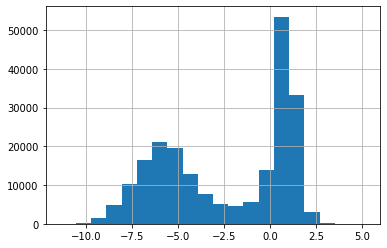

In [15]:
protein_data['score'].hist(bins=20)

Check that allseqs data is similar

In [16]:
# Classify the selection coeff series after fitting to a GMM
gmm_model = TwoGaussianMixtureModelLabeler(
    protein_data[protein_data.category.isin(['stop', 'wild_type'])].score)

protein_data['viral_selection_gmm'] = gmm_model.predict(protein_data.score)

# Compute the threshold for the viable class from the GMM labels
selection_coeff_threshold = protein_data.loc[protein_data.viral_selection_gmm == 2, 'score'].min()
print('selection coeff cutoff = %.3f' % selection_coeff_threshold)

# Add a label column
def is_viable_mutant(mutant_data):
    return mutant_data['score'] > selection_coeff_threshold

protein_data['binary_score'] = protein_data.apply(is_viable_mutant, axis=1)

print(protein_data.binary_score.mean())

selection coeff cutoff = -0.815
0.49173347278185797


In [17]:
design_train = [
    'previous_chip_viable', 'previous_chip_nonviable', 
    'stop', 'singles', 'wild_type', 'random_doubles'
]

design_test = [
    'rnn_designed_plus_rand_train_walked',
    'rnn_designed_plus_rand_train_seed',
    'rnn_rand_doubles_plus_singles_walked',
    'rnn_rand_doubles_plus_singles_seed', 'rnn_standard_walked',
    'rnn_standard_seed', 'cnn_designed_plus_rand_train_walked',
    'cnn_designed_plus_rand_train_seed',
    'cnn_rand_doubles_plus_single_walked',
    'cnn_rand_doubles_plus_single_seed', 'cnn_standard_walked',
    'cnn_standard_seed', 'lr_designed_plus_rand_train_walked',
    'lr_designed_plus_rand_train_seed',
    'lr_rand_doubles_plus_single_walked',
    'lr_rand_doubles_plus_single_seed', 'lr_standard_walked',
    'lr_standard_seed'
]

def design_task(category):
    if category in design_train:
        return "train"
    elif category in design_test:
        return "test"
    else:
        return "unknown"
    
def design_task_reversed(category):
    if category in design_train:
        return "test"
    elif category in design_test:
        return "train"
    else:
        return "unknown"

protein_data['design_task'] = protein_data.category.apply(design_task)
protein_data['design_task_reversed'] = protein_data.category.apply(design_task_reversed)

In [18]:
natural_allowed = [
    'previous_chip_viable', 'previous_chip_nonviable', 
    'stop', 'singles', 'wild_type', 'random_doubles'
]

# randomly pick a few, see distribution of mutations
def natural_task_1(category):
    if category in natural_allowed:
        return random.choices(['train', 'test'], weights=[0.8, 0.2], k=1)[0]
    else:
        return "unknown"

# from train, those w/ many mutations

num_mutations_threshold = 7

test_count = len(protein_data[protein_data.number_of_mutations > num_mutations_threshold])
total = len(protein_data)

test_percentage = (test_count*100)/total

print(f'The test set will be {test_percentage}% of the data.')

def natural_task_2(row):
    if row.category in natural_allowed:
        if row.number_of_mutations > num_mutations_threshold:
            return "test"
        else:
            return "train"
    else:
        return "unknown"
    

protein_data['natural_task_1'] = protein_data.category.apply(natural_task_1)
protein_data['natural_task_2'] = protein_data.apply(natural_task_2, axis=1)

The test set will be 75.2653179379672% of the data.


In [19]:
# Random sample n sequences from train k times for single shot learning approaches

n = 96
k = 100

protein_data['natural_task_1_random_train_set'] = 'unassigned'
protein_data['natural_task_2_random_train_set'] = 'unassigned'

natural_task_1_train = protein_data.query('natural_task_1 == "train"')
natural_task_1_train_index = list(natural_task_1_train.index)

natural_task_1_kn_indexes = numpy.array(random.sample(natural_task_1_train_index, k=k*n)).reshape(k,n)

for i, kn_index in enumerate(natural_task_1_kn_indexes):
    protein_data.loc[kn_index, 'natural_task_1_random_train_set'] = f"S{i+1}"
    
natural_task_2_train = protein_data.query('natural_task_2 == "train"')
natural_task_2_train_index = list(natural_task_2_train.index)

natural_task_2_kn_indexes = numpy.array(random.sample(natural_task_2_train_index, k=k*n)).reshape(k,n)

for i, kn_index in enumerate(natural_task_2_kn_indexes):
    protein_data.loc[kn_index, 'natural_task_2_random_train_set'] = f"S{i+1}"

In [20]:
# Check how much are in test/train for each set

def get_stats(task_name):
    return f"""
    Set {task_name} has {
      len(protein_data.query(f"{task_name}=='train'"))
    } train and {
      len(protein_data.query(f"{task_name}=='test'"))
    } test sequences. {
      round(len(protein_data.query(f"{task_name}=='test' & binary_score==True")) / 
      len(protein_data.query(f"{task_name}=='test'")) * 100)
    }% of test is positive.
    """

print(get_stats("design_task"))
print(get_stats("design_task_reversed"))
print(get_stats("natural_task_1"))
print(get_stats("natural_task_2"))


    Set design_task has 28102 train and 186075 test sequences. 55% of test is positive.
    

    Set design_task_reversed has 186075 train and 28102 test sequences. 12% of test is positive.
    

    Set natural_task_1 has 22497 train and 5605 test sequences. 12% of test is positive.
    

    Set natural_task_2 has 27661 train and 441 test sequences. 13% of test is positive.
    


In [21]:
# Add reference region for completeness
protein_data['reference_region'] = reference_region

protein_data[
    ['mutation_mask', 'mutated_region', 'category', 'number_of_mutations',
    'levenshtein_distance', 'score', 'full_aa_sequence', 'binary_score', 'reference_region',
    'design_task', 'design_task_reversed', 'natural_task_1', 'natural_task_2',
    'natural_task_1_random_train_set', 'natural_task_2_random_train_set']
].to_csv(task_path / "full_data.csv", index=False)

In [22]:
ml_categories = ['train','test']

# Design regression
design_task_regression = protein_data[protein_data.design_task.isin(ml_categories)]
design_task_regression = design_task_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'design_task': 'set',
}, axis=1)

design_task_regression[
    ['sequence', 'target', 'set']
].to_csv(task_path / 'tasks' / "design_task_regression.csv", index=False)

del design_task_regression

# Design binary
design_task_binary = protein_data[protein_data.design_task.isin(ml_categories)]
design_task_binary = design_task_binary.rename({
    'full_aa_sequence': 'sequence',
    'binary_score': 'target',
    'design_task': 'set',
}, axis=1)

design_task_binary[
    ['sequence', 'target', 'set']
].to_csv(task_path / 'tasks' / "design_task_binary.csv", index=False)

del design_task_binary

# Design reversed regression
design_task_reversed_regression = protein_data[protein_data.design_task_reversed.isin(ml_categories)]
design_task_reversed_regression = design_task_reversed_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'design_task_reversed': 'set',
}, axis=1)

design_task_reversed_regression[
    ['sequence', 'target', 'set']
].to_csv(task_path / 'tasks' / "design_task_reversed_regression.csv", index=False)

del design_task_reversed_regression

# Design reversed binary
design_task_reversed_binary = protein_data[protein_data.design_task_reversed.isin(ml_categories)]
design_task_reversed_binary = design_task_reversed_binary.rename({
    'full_aa_sequence': 'sequence',
    'binary_score': 'target',
    'design_task_reversed': 'set',
}, axis=1)

design_task_reversed_binary[
    ['sequence', 'target', 'set']
].to_csv(task_path / 'tasks' / "design_task_reversed_binary.csv", index=False)

del design_task_reversed_binary

# Natural 1 regression
natural_task_1_regression = protein_data[protein_data.natural_task_1.isin(ml_categories)]
natural_task_1_regression = natural_task_1_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'natural_task_1': 'set',
    'natural_task_1_random_train_set': 'random_sample'
}, axis=1)

natural_task_1_regression[
    ['sequence', 'target', 'set', 'random_sample']
].to_csv(task_path / 'tasks' / "natural_task_1_regression.csv", index=False)

del natural_task_1_regression

# Natural 1 binary
natural_task_1_binary = protein_data[protein_data.natural_task_1.isin(ml_categories)]
natural_task_1_binary = natural_task_1_binary.rename({
    'full_aa_sequence': 'sequence',
    'binary_score': 'target',
    'natural_task_1': 'set',
    'natural_task_1_random_train_set': 'random_sample'
}, axis=1)

natural_task_1_binary[
    ['sequence', 'target', 'set', 'random_sample']
].to_csv(task_path / 'tasks' / "natural_task_1_binary.csv", index=False)

del natural_task_1_binary

# Natural 2 regression
natural_task_2_regression = protein_data[protein_data.natural_task_2.isin(ml_categories)]
natural_task_2_regression = natural_task_2_regression.rename({
    'full_aa_sequence': 'sequence',
    'score': 'target',
    'natural_task_2': 'set',
    'natural_task_2_random_train_set': 'random_sample'
}, axis=1)

natural_task_2_regression[
    ['sequence', 'target', 'set', 'random_sample']
].to_csv(task_path / 'tasks' / "natural_task_2_regression.csv", index=False)

del natural_task_2_regression

# Natural 2 binary
natural_task_2_binary = protein_data[protein_data.natural_task_2.isin(ml_categories)]
natural_task_2_binary = natural_task_2_binary.rename({
    'full_aa_sequence': 'sequence',
    'binary_score': 'target',
    'natural_task_2': 'set',
    'natural_task_2_random_train_set': 'random_sample'
}, axis=1)

natural_task_2_binary[
    ['sequence', 'target', 'set', 'random_sample']
].to_csv(task_path / 'tasks' / "natural_task_2_binary.csv", index=False)

del natural_task_2_binary